# Supplemental Code for "Artificial Intelligence and the Interpretation of the Past: A Multimodal Encoding Approach"

The code and data in this repository can be used to replicate the analysis in Magnani and Clindaniel "Artificial Intelligence and the Interpretation of the Past: A Multimodal Encoding Approach". The code that follows uses the OpenAI API to generate text and images in response to a prompt asking for information about "a day in the life of a neandertal." It then compares the AI-generated content to a large scholarly corpus of text about neandertals by encoding the scholarly text and AI-generated content into the same multimodal embedding space (CLIP).

The code is written in Python 3.11.7 (as distributed via Anaconda version 2023.07-2, which can be downloaded for your operating system [here](https://repo.anaconda.com/archive/)). The dependencies not included in the Anaconda distribution can be installed by running the following in the terminal (with the `requirements.txt` file included in this repository).

```
pip install -r requirements.txt
```

Once all the dependencies are installed, the replication code below can be run (either in a Python interpreter, or via `README.ipynb` in this repository). First, let's load in the packages we will use to perform the analysis:

In [1]:
from openai import OpenAI, OpenAIError
import time
import re
import pandas as pd
import numpy as np
from transformers import CLIPProcessor, CLIPModel
import requests
from PIL import Image
import umap
import hdbscan
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.spatial.distance import cdist
from gensim.models import TfidfModel
from gensim.corpora import Dictionary
from gensim.utils import simple_preprocess
from gensim.models.phrases import Phrases
import nltk
nltk.download('stopwords', quiet=True)

# Random seed we will use to fix output of UMAP/HDBSCAN for replication
SEED = 0

# load pretrained CLIP model to encode embeddings for images and text
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")

## Generating and Encoding AI-generated Content as CLIP embeddings

In order to produce AI-generated content, we employed the OpenAI API to interact with DALL-E 3 and ChatGPT 3.5 programmatically. The following code uses the API to generate image and text content, save it to the current directory (the exact images and text responses we received are available for inspection in this repository), and finally encode the resulting images and text as CLIP embeddings so that they can compared against one another as well as scholarly content on neandertals.

The content generation and encoding process takes a long time to complete, requires the user to pay for OpenAI credits, and will produce slightly different results every time (given the stochasticity of the underlying generative AI models). Therefore, we have saved the exact images and text responses that we received in this repository for inspection. We have also saved the CLIP embeddings for each AI-generated image and text, which can be read in as files for further analysis in the "Comparing Abstract Embeddings to AI Generated Text and Image Embeddings" section of this notebook.

To fully replicate the process by which we generated AI content and encoded it into the CLIP embedding space, you can set the `GENERATE_AI_CONTENT` variable to `True` in the cell below to generate your own AI content. Note that the cell assumes that you have an OpenAI API key and that you have saved this key as an environment variable on your computer called `OPENAI_API_KEY`. For more information on using the OpenAI API, consult [the documentation](https://platform.openai.com/docs/introduction).

In [2]:
GENERATE_AI_CONTENT = False
if GENERATE_AI_CONTENT:
    # Follow OpenAI instructions to set up API key
    client = OpenAI()

### Generate Images with DALL-E 3

The following functions call the OpenAI API to generate and download an image for a given text prompt.

In [3]:
def download_image(img_url, input_text, revised_text):
    log_path = 'image_download_log.txt'

    try:
        r = requests.get(img_url)
        file_path = re.findall('/(img.+\.png)', img_url)[0]
        with open(file_path, 'wb') as output:
            output.write(r.content)
    except:
        print('Failed to download {}'.format(img_url))

    try:
        with open(log_path, "a") as image_log:
            image_log.write(f"{input_text} | {revised_text} | {file_path}\n")
    except:
        print('Failed to log metadata for {} to {}'.format(img_url, log_path))


def generate_image(input_text, size='1024x1024'):
    try:
        r_openai = client.images.generate(
            model="dall-e-3",
            prompt=input_text,
            size=size
        )
    except OpenAIError as e:
        print(e)

    img_url, revised_text = r_openai.data[0].url, r_openai.data[0].revised_prompt
    download_image(img_url, input_text, revised_text)

We used the functions above to generate 100 images corresponding to each of the following text prompts (one that is a general prompt asking DALL-E 3 to depict a day in the life of a neandertal and another that asks the model to the same, but to take on the role of an "expert in neandertal behavior"). Note that before generating an image, DALL-E 3 uses an AI text generation model to revise user-input prompts to a longer, more detailed prompt if the user does not specify otherwise. 

We generated images using both the revised and unrevised versions of the same prompts to compare the difference between the two. We then placed the images in the `generated_images/` directory in this repository (along with their corresponding prompts and revisions in `image_download_log.txt`) for inspection.

In [4]:
# prompts for generating images (general, expert, allowing revisions, and not allowing text revisions)
prompts = [
    'image depicting a day in the life of a neandertal, digital art',
    'image depicting a day in the life of a neandertal, digital art, based on expert knowledge of neandertal behavior',
    'I NEED to test how the tool works with extremely simple prompts. DO NOT add any detail, just use it AS-IS: image depicting a day in the life of a neandertal, digital art',
    'I NEED to test how the tool works with extremely simple prompts. DO NOT add any detail, just use it AS-IS: image depicting a day in the life of a neandertal, digital art, based on expert knowledge of neandertal behavior'
]

# number of images to generate for each prompt
n = 100

if GENERATE_AI_CONTENT:
    for p in prompts:
        print(f'Generating {n} images based on the prompt: {p}')
        for i in range(n):
            t0 = time.time()
            generate_image(p)
            t1 = time.time()

            if t1 - t0 < 10:
                # ensure that we only produce 1 image every 10+ seconds to stay under API rate limit
                time.sleep(abs(10 - (t1 - t0)))
else:
    print('Images already generated.')

Images already generated.


We then encoded each image as a CLIP embedding. We also encoded the revised prompts that were generated by DALL-E 3 (for the images where we allowed the model to make prompt revisions), so that we could better understand the characteristics of these revised prompts as well.

In [5]:
if GENERATE_AI_CONTENT:
    image_log = pd.read_csv('./generated_images/image_download_log.txt', sep='|', names=['prompt', 'revised_prompt', 'image_file'])
    images = [Image.open('generated_images/' + img[1:]) for img in image_log.image_file]

    revised_prompt_chunks = image_log.revised_prompt.apply(lambda x: [x[35 * i: 35 * (i + 1)]
                                            for i in range(len(x))
                                            if len(x[35 * i: 35 * (i + 1)]) > 0]) \
                                    .explode()

    inputs = processor(text=revised_prompt_chunks.to_list(),
                    images=images,
                    return_tensors='pt',
                    padding=True)

    outputs = model(**inputs)

    revised_prompt_chunk_embeds = pd.DataFrame(revised_prompt_chunks)
    revised_prompt_chunk_embeds.loc[:, 'embed'] = outputs.text_embeds.detach().numpy().tolist()
    image_log.loc[:, 'revised_prompt_embed'] = \
        revised_prompt_chunk_embeds.embed.apply(lambda x: np.asarray(x)) \
                                .groupby(revised_prompt_chunk_embeds.index) \
                                .mean()
    image_log.loc[:, 'image_embed'] = pd.Series(outputs.image_embeds.detach().numpy().tolist()).apply(lambda x: np.asarray(x))

    image_log.to_pickle('gen_img_embeds.pkl')

print('AI-generated Images and Prompt Revisions are encoded as CLIP embeddings in gen_img_embeds.pkl')

AI-generated Images and Prompt Revisions are encoded as CLIP embeddings in gen_img_embeds.pkl


### Text Generation with ChatGPT

Then, we used the following functions to prompt the ChatGPT API and write the prompts/responses to file. The responses we received to each prompt are saved in `./chat_log.txt` in this repository.

In [6]:
def generate_text(user_prompt, system_prompt=None):
    try:
        if system_prompt:
            response_chat = client.chat.completions.create(
                model="gpt-3.5-turbo",
                messages=[
                    {"role": "system", "content": system_prompt},
                    {"role": "user", "content": user_prompt}
                ]
            )
        else:
            response_chat = client.chat.completions.create(
                model="gpt-3.5-turbo",
                messages=[
                    {"role": "user", "content": user_prompt}
                ]
            )
    except OpenAIError as e:
        print(e)

    log_path = 'chat_log.txt'
    try:
        with open(log_path, "a") as chat_log:
            chat_log.write(f"{user_prompt} | {system_prompt} | {response_chat.choices[0].message.content}\n")
    except:
        print(f"Failed to log metadata for {user_prompt} to {log_path}")

We generated 100 text samples for two prompts -- one prompt asking the model to describe a day in the life of a neandertal, and another asking the model to do the same as "an expert in neandertal behavior." These prompts were designed to be as analogous as possible to the prompts we employed for image generation with DALL-E 3. Likewise, we asked the model to fit its description into one paragraph to make the output as comparable as possible to scholarly abstracts on neandertals (which we will compare these text and image responses against).

In [7]:
if GENERATE_AI_CONTENT:
    for i in range(100):
        generate_text('describe a day in the life of a neandertal in one paragraph')
    
    # same prompt, but instruct ChatGPT to take on the role of "an expert in neandertal behavior"
    for i in range(100):
        generate_text('describe a day in the life of a neandertal in one paragraph', system_prompt='you are an expert on neandertal behavior')

    print('AI-generated Text (ChatGPT) has been generated and saved to chat_log.txt')
else:
    print('AI-generated Text (ChatGPT) has already been generated and saved to chat_log.txt')

AI-generated Text (ChatGPT) has already been generated and saved to chat_log.txt


We then encoded each response as a CLIP embedding:

In [8]:
if GENERATE_AI_CONTENT:
    chat_log = pd.read_csv('./chat_log.txt', sep='|', names=['user_prompt', 'system_prompt', 'response'])
    # CLIP processor can only take 77 token inputs, so split up response text into smaller chunks
    chat_response_chunks = chat_log.response.apply(lambda x: [x[35 * i: 35 * (i + 1)]
                                                   for i in range(len(x))
                                                   if len(x[35 * i: 35 * (i + 1)]) > 0]) \
                                            .explode()

    chat_inputs = processor(text=chat_response_chunks.to_list(),
                            images=images[:1],
                            return_tensors='pt',
                            padding=True)

    chat_outputs = model(**chat_inputs)

    chat_response_chunk_embeds = pd.DataFrame(chat_response_chunks)
    chat_response_chunk_embeds.loc[:, 'embed'] = chat_outputs.text_embeds.detach().numpy().tolist()
    
    # Average embeddings across chunks to compute full-response embedding
    chat_log.loc[:, 'chat_response_embed'] = \
        chat_response_chunk_embeds.embed.apply(lambda x: np.asarray(x)) \
                                        .groupby(chat_response_chunk_embeds.index) \
                                        .mean()

    chat_log.to_pickle('chat_response_embeds.pkl')

print('AI-generated Text (ChatGPT) are encoded as CLIP embeddings in chat_response_embeds.pkl')

AI-generated Text (ChatGPT) are encoded as CLIP embeddings in chat_response_embeds.pkl


## Exploring Neandertal Article Data on JSTOR

We collected data about all articles (through 2023) on JSTOR with the word "neandertal" or "neanderthal" in them using [Constellate Dataset Builder](https://constellate.org/). The data we used can be downloaded in a compressed `jsonl` format via the URL in the citation below (we are using [Constellate's recommended citation practices for the dataset](https://constellate.org/docs/how-to-cite-a-constellate-dataset), and have not included the dataset again in this repository. It will need to be downloaded to replicate the summary statistics in this section of the notebook, but is not required to replicate the main quantitative and qualitative analyses presented in the "Comparing Abstract Embeddings to AI Generated Text and Image Embeddings" section of this notebook.):

*Use of Terms Neandertal and Neanderthal in Scholarly Content between 1900-2023*. January 2024. Distributed by Constellate. https://constellate.org/dataset/912f20af-3446-c463-bbde-4daeeb8f58a2/.

In [9]:
# unzip compressed jsonl file and read in using pandas:
df = pd.read_json('all_neandertal_data.jsonl', lines=True)

While we have over 6000 articles with metadata recorded (e.g. publication year, title, etc.) in the dataset, only a small subset have substantial text data (either full or abstract text) available for analysis:

In [10]:
print('Entries that include...',
'\nTitle: ', df.title.notna().sum(),
'\nPublication Year: ', df.publicationYear.notna().sum(),
'\nFull text: ', df.fullText.notna().sum(),
'\nAbstract ', df.abstract.notna().sum()
)

Entries that include... 
Title:  6351 
Publication Year:  6351 
Full text:  378 
Abstract  2063


The overall dataset features articles from nearly all of the years in the dataset, but there is an increase from the 1990s through today (the low numbers in the final years reflect the lag in time between when an article is published and when it is incorporated into JSTOR's corpus):

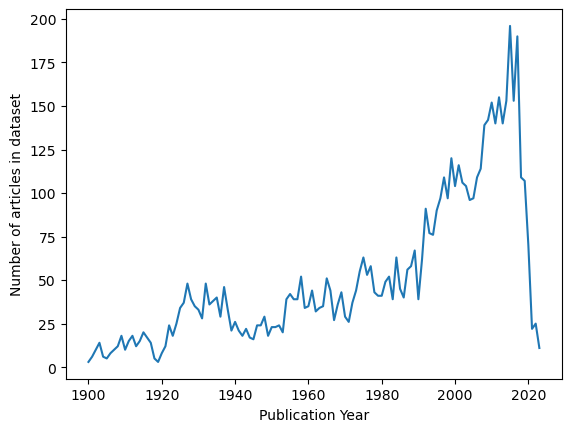

In [11]:
df.groupby('publicationYear').publicationYear \
  .count() \
  .plot(xlabel='Publication Year', 
        ylabel='Number of articles in dataset');

It looks like the articles with full text are not very representative of the age distribution of the articles about neandertals on JSTOR. Copyrighted works from 1927 entered US public domain on January 1st 2023 (which was the latest available public domain data at the time of study), so the majority of the full-text data comes from 1927 and earlier. The next peak in the full-text distribution occurs in the 2000s, around the time when open access increased in popularity.

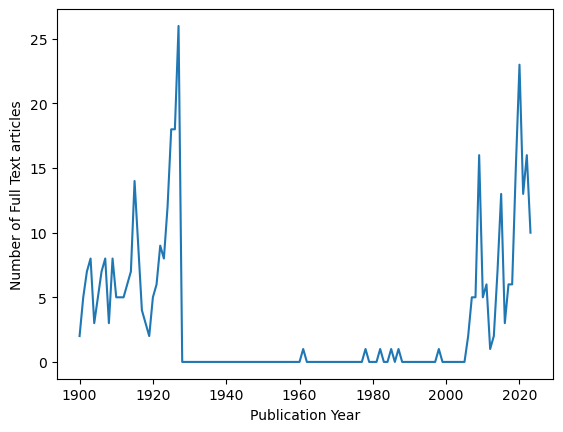

In [12]:
full_text_counts = df[df.fullText.notna()].groupby('publicationYear').fullText.count()
full_year_range = pd.Series(np.arange(1900, 2024), name='publicationYear')
pd.merge(full_year_range, full_text_counts, how='outer', on='publicationYear').fillna(0).plot(x='publicationYear',
                                                                                              xlabel='Publication Year',
                                                                                              ylabel='Number of Full Text articles', 
                                                                                              legend=False);

In [13]:
print(f'Percentage of full text articles from 1927 or before: {round(full_text_counts.loc[:1927].sum() / full_text_counts.sum() * 100, 2)}%')

Percentage of full text articles from 1927 or before: 57.67%


The number of abstracts available by year more closely matches the overall distribution of available articles -- making the abstracts a more representative sample of the overall scholarly text data that is available. Nonetheless, there are few samples from before the 1970s.

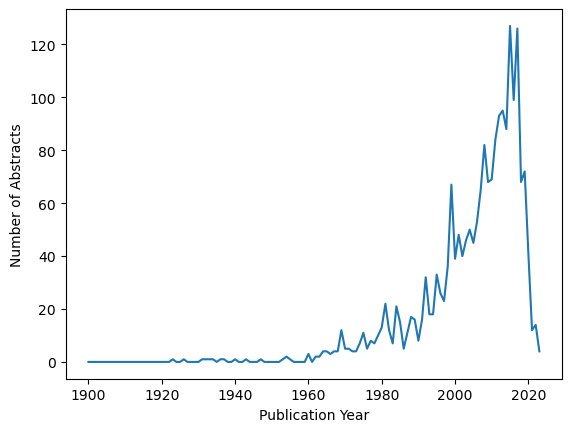

In [14]:
abstract_counts = df[df.abstract.notna()].groupby('publicationYear').abstract.count()
full_year_range = pd.Series(np.arange(1900, 2024), name='publicationYear')
pd.merge(full_year_range, abstract_counts, how='outer', on='publicationYear').fillna(0).plot(x='publicationYear',
                                                                                  xlabel='Publication Year',
                                                                                  ylabel='Number of Abstracts', 
                                                                                  legend=False);

Therefore, to model the semantic space of neandertal scholarship, we select all available abstracts about neandertals ($n=2063$) for further processing. Note that available abstracts come from a broad range of relevant journals within the field and represent a good cross-section of scholarship in this domain.

In [15]:
abstracts_by_year = df[df.abstract.notna()].reset_index()
abstracts_by_year.groupby('isPartOf').id.count().sort_values(ascending=False).head(20)

isPartOf
Proceedings of the National Academy of Sciences of the United States of America    294
Anthropologie (1962-)                                                              133
Current Anthropology                                                               126
Philosophical Transactions: Biological Sciences                                     88
Science                                                                             86
Paléorient                                                                          61
Journal of Archaeological Method and Theory                                         55
Proceedings: Biological Sciences                                                    54
Journal of Anthropological Research                                                 50
Evolution                                                                           49
American Anthropologist                                                             44
Human Biology                     

## Encoding Neandertal article abstracts as CLIP embeddings

In order to compare AI-generated content to these abstracts, we must encode the abstracts into the same CLIP embedding space as the AI-generated content. This encoding process takes a long time to run (several hours on an average laptop), and the results of this encoding are written to `abstract_embeds.pkl`, which is included in this repository. Therefore, it is recommended to keep the `REPRODUCE_ABSTRACT_ENCODING` variable set to `False` in the cell below and read in the resulting embeddings in the following "Comparing Abstract Embeddings to AI Generated Text and Image Embeddings" section of this notebook.

In [16]:
REPRODUCE_ABSTRACT_ENCODING = False

if REPRODUCE_ABSTRACT_ENCODING:
    # CLIP processor can only take 77 token inputs, so split up abstracts into chunks
    abstract_chunks = abstracts_by_year.abstract.apply(lambda x: [x[30 * i: 30 * (i + 1)]
                                                                for i in range(len(x))
                                                                if len(x[30 * i: 30 * (i + 1)]) > 0]) \
                                                .explode()
    
    abstract_inputs = processor(text=abstract_chunks.to_list(),
                            images=images[:1],
                            return_tensors='pt',
                            padding=True)

    abstract_outputs = model(**abstract_inputs)

    abstract_chunk_embeds = pd.DataFrame(abstract_chunks)
    abstract_chunk_embeds.loc[:, 'embed'] = abstract_outputs.text_embeds.detach().numpy().tolist()

    # Compute avg embedding for each abstract across chunks
    abstracts_by_year.loc[:, 'embed'] = \
        abstract_chunk_embeds.embed.apply(lambda x: np.asarray(x)) \
                                .groupby(abstract_chunk_embeds.index) \
                                .mean()

    # save df with abstract embeddings, publication year, and abstract to file
    abstracts_by_year.loc[:, ['publicationYear', 'abstract', 'embed']].to_pickle('abstract_embeds.pkl')

print('Abstracts are encoded as CLIP embeddings in abstract_embeds.pkl')

Abstracts are encoded as CLIP embeddings in abstract_embeds.pkl


## Comparing Abstract Embeddings to AI Generated Text and Image Embeddings

Now that we have encoded all of our AI-generated content and scholarly content into CLIP embeddings, we are ready to compare AI-generated content (image and text) to scholarly abstract embeddings. To avoid re-running the computationally-intensive encoding steps above each time this notebook is run, we can read in the embedding dataframes here (which will be used for the remainder of our analysis):

In [17]:
abstract_embeds = pd.read_pickle('abstract_embeds.pkl')
chat_response_embeds = pd.read_pickle('chat_response_embeds.pkl')
gen_img_embeds = pd.read_pickle('gen_img_embeds.pkl')

### Identifying "average" AI-generated content for each category

Our next step in comparing AI-generated embeddings to scholarly abstract embeddings is to compute the average embedding in each category of AI-generated content. We then interpret how these average examples of AI-generated content compare to scholarly content both quantitatively and qualitatively.

In [18]:
gen_img_embeds_np = {k: {'img_path': gen_img_embeds[i:i + 100].image_file.str.strip(' ').reset_index(drop=True),
                         'img_embeds': np.array(gen_img_embeds[i:i + 100].image_embed.values.tolist()),
                         'img_avg': np.array(gen_img_embeds[i:i + 100].image_embed.values.tolist()).mean(axis=0),
                         'revised_prompt_embeds': np.array(gen_img_embeds[i:i + 100].revised_prompt_embed.values.tolist()),
                         'revised_prompt_avg': np.array(gen_img_embeds[i:i + 100].revised_prompt_embed.values.tolist()).mean(axis=0)
                        } 
                         for k, i in zip(['rev_general', 'rev_expert', 'norev_general', 'norev_expert'], range(0, 400, 100))
                    }
chat_response_embeds_np = {k: {'embeds': np.array(chat_response_embeds[i:i + 100].chat_response_embed.values.tolist()),
                               'avg': np.array(chat_response_embeds[i:i + 100].chat_response_embed.values.tolist()).mean(axis=0),
                              }
                              for k, i in zip(['general', 'expert'], range(0, 200, 100))
                          }

We based our qualitative interpretations in the article based on the closest AI-generated content to the average embedding in each category. For instance, the closest ChatGPT and Prompt Revision responses to the average embedding for each category are as follows:

In [19]:
for i, k in enumerate(chat_response_embeds_np.keys()):
    idx = np.argmin(cdist(chat_response_embeds_np[k]['embeds'], 
                          chat_response_embeds_np[k]['avg'].reshape(1,-1),
                          'cosine').reshape(-1))

    closest_response = None
    if k == 'general':
        closest_response = chat_response_embeds.iloc[idx].response.strip(' ')
    elif k == 'expert':
        idx += 100
        closest_response = chat_response_embeds.iloc[idx].response.strip(' ')

    print(f"For {k} category, the closest to the average generated ChatGPT response was at index {idx}: '{closest_response}'")

for k in gen_img_embeds_np.keys():
    if 'no' not in k:
        idx = np.argmin(cdist(gen_img_embeds_np[k]['revised_prompt_embeds'], 
                          gen_img_embeds_np[k]['revised_prompt_avg'].reshape(1,-1),
                          'cosine').reshape(-1))
        closest_img = gen_img_embeds_np[k]['img_path'].iloc[idx]
        revised_prompt = gen_img_embeds[closest_img == gen_img_embeds.image_file.str.strip(' ')].revised_prompt \
                                                                                                .values[0] \
                                                                                                .strip(' ')    

        print(f"For {k} category, the closest to the average generated prompt revision for image generation was at index, corresponding to image {closest_img}: {revised_prompt}")

For general category, the closest to the average generated ChatGPT response was at index 76: 'A Neanderthal wakes up early in the morning as the sun rises, emerging from their cozy cave dwelling. They gather their tools made of stone and wood before setting out to hunt for food in the nearby forests. With their keen senses and strong physique, they stalk and capture a wild boar, using their sharp spears and teamwork to bring it down. After a successful hunt, they return to their cave and share the food with their family and tribe, enjoying a hearty meal together. The rest of the day is spent working on various tasks such as making clothing from animal hides, crafting tools, and tending to the fire. As the sun sets, the Neanderthal settles down for the night, feeling content and grateful for another day of survival in the harsh prehistoric world.'
For expert category, the closest to the average generated ChatGPT response was at index 195: 'A typical day in the life of a Neanderthal woul

We also identified the AI-generated images that were closest to the average embedding for each category:

For rev_general category, img-LT1c6U7e5TA7jNTBGaze9gI5.png is closest to the average generated image.
The revised prompt it employed for producing the image was: 'Create a digital art piece illustrating a typical day in the life of a Neanderthal. The scene should depict a Neanderthal carrying out daily activities such as hunting, foraging, making tools, or communicating with others in their group. The setting should be prehistoric, with the environment consisting of wild, untouched landscapes, boulders, caves, or primitive shelters. Additionally, include details like the rough and sturdy attire of the Neanderthal and their hand-made tools.'
For rev_expert category, img-q5JzE1tw89gf2QN4MI9A8SIr.png is closest to the average generated image.
The revised prompt it employed for producing the image was: 'A detailed digital art image illustrating a day in the life of a Neandertal, based on scientifically validated knowledge about their behavior. The image includes scenes that show them hunti

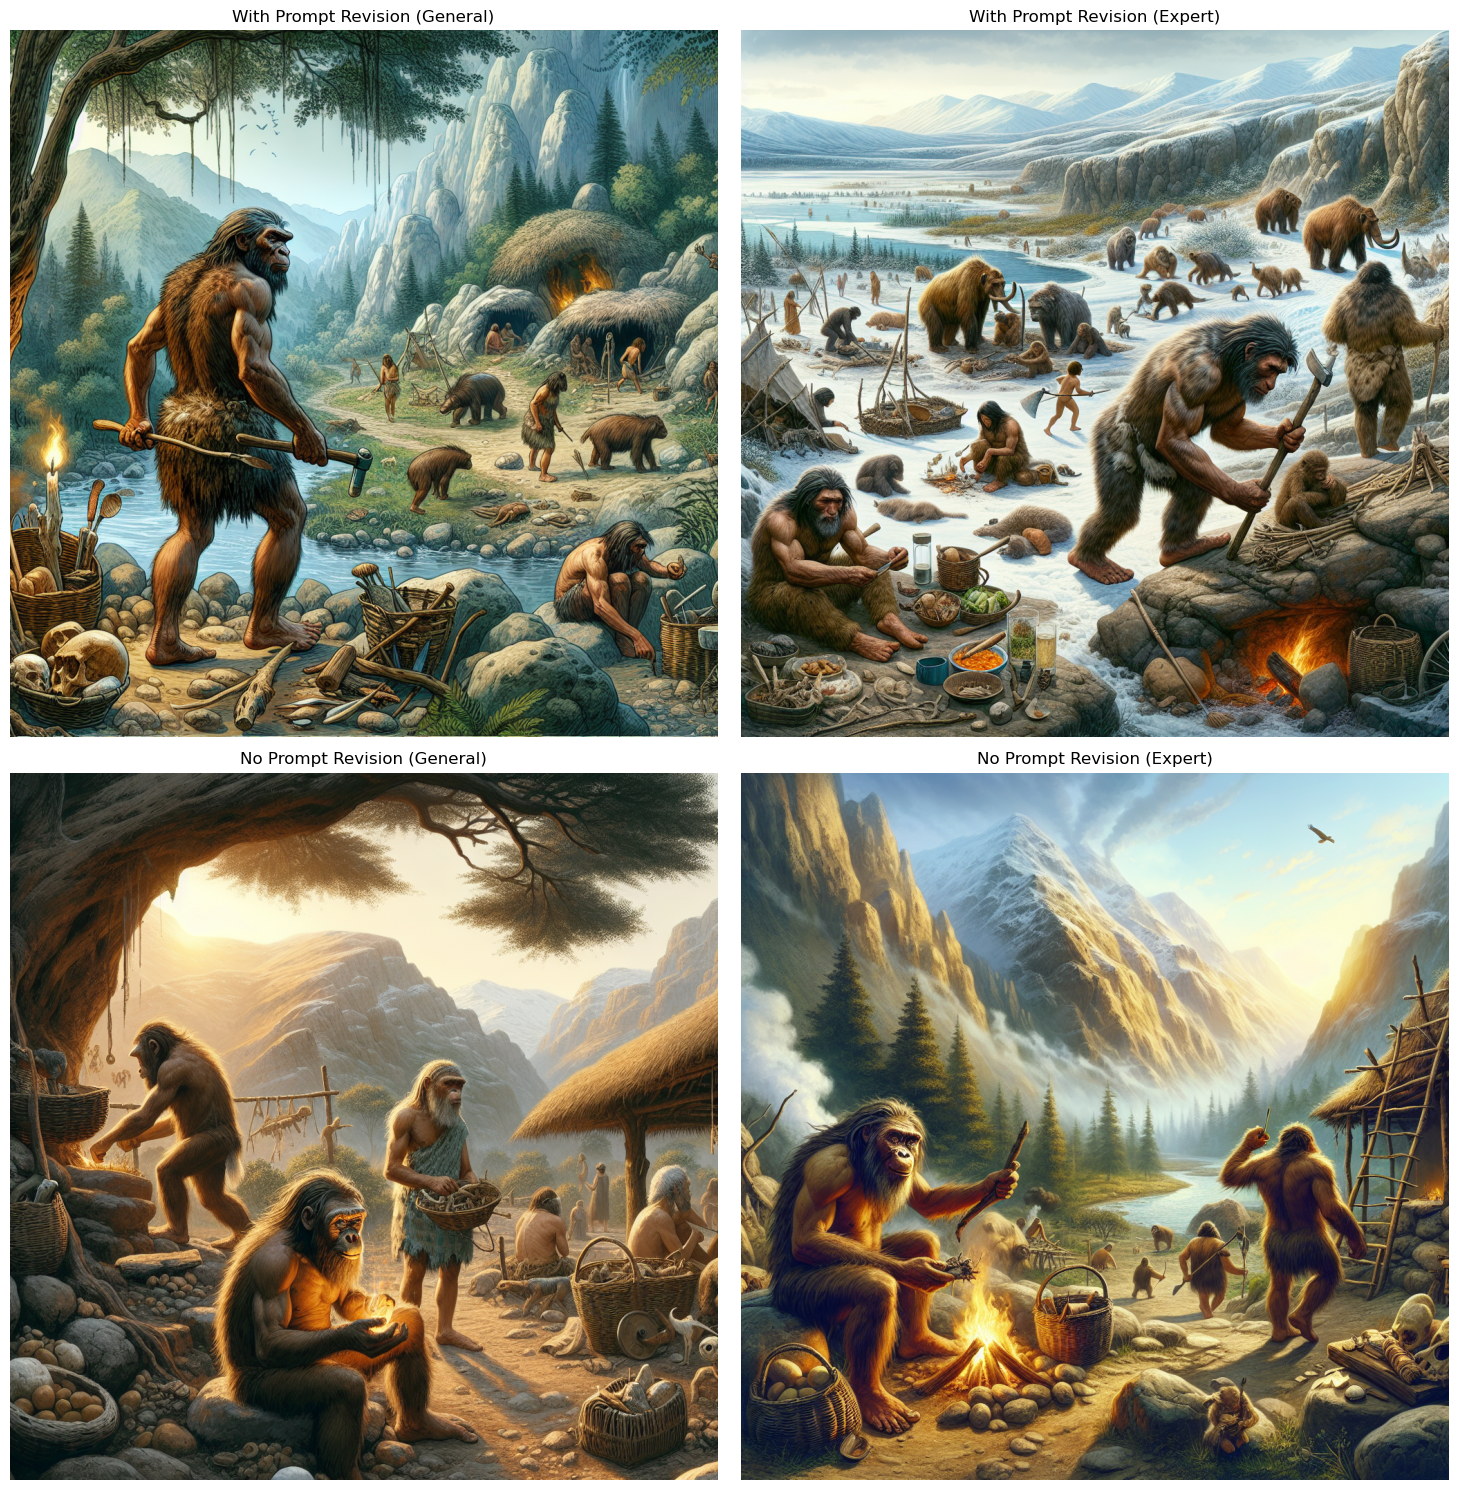

In [20]:
cat_to_title = {'norev_general': 'No Prompt Revision (General)',
                'norev_expert': 'No Prompt Revision (Expert)',
                'rev_general': 'With Prompt Revision (General)',
                'rev_expert': 'With Prompt Revision (Expert)'}

fig, axs = plt.subplots(2, 2, figsize=(15, 15), layout='tight')
axs = axs.flatten()
for i, k in enumerate(gen_img_embeds_np.keys()):
    idx = np.argmin(cdist(gen_img_embeds_np[k]['img_embeds'], 
                          gen_img_embeds_np[k]['img_avg'].reshape(1,-1),
                          'cosine').reshape(-1))
    closest_img = gen_img_embeds_np[k]['img_path'].iloc[idx]
    
    print(f"For {k} category, {closest_img} is closest to the average generated image.")
    if 'no' not in k:
        revised_prompt = gen_img_embeds[closest_img == gen_img_embeds.image_file.str.strip(' ')].revised_prompt \
                                                                                                .values[0] \
                                                                                                .strip(' ')
        print(f"The revised prompt it employed for producing the image was: '{revised_prompt}'")
    
    # Plot images
    img = mpimg.imread(f"./generated_images/{closest_img}")
    axs[i].imshow(img)
    axs[i].set_title(cat_to_title[k])
    axs[i].axis('off')

### Identifying clusters of scholarly content and predicting the cluster membership of AI-generated content

To quantitatively assess how AI-generated neandertal content compares to scholarly content, we identified clusters of scholarly content using a combination of UMAP and HDBSCAN (using a strategy akin to BERTopic to identify distinct semantic clusters in the CLIP embedding space). Then, we predicted which cluster the average embedding for each AI-generated content category was most likely to fall within.

c:\Users\jclindaniel\AppData\Local\anaconda3\envs\ai_inf\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\jclindaniel\AppData\Local\anaconda3\envs\ai_inf\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(array([0, 0, 0, 0, 0, 0, 0, 0]), array([0.7543059 , 0.87684935, 1.        , 0.80562525, 0.79349493,
       0.90709527, 0.58494115, 0.77951637]))


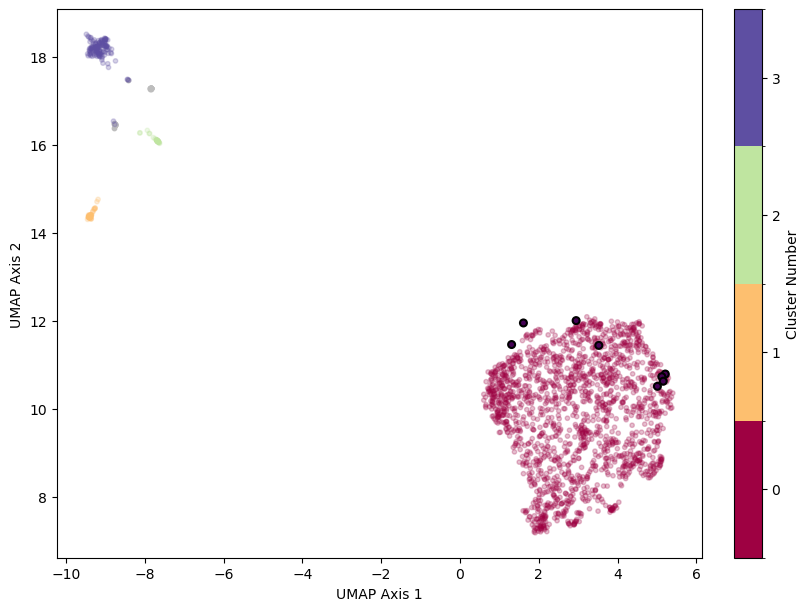

In [21]:
# Initial pass to compress data to lower dimensions for clustering
abstract_embeds_np = np.array(abstract_embeds.embed.values.tolist())
umap_50comp_model = umap.UMAP(n_neighbors=30,
                            n_components=10,
                            min_dist=0.0,
                            metric='cosine',
                            random_state=SEED) \
                      .fit(abstract_embeds_np)

# Identify clusters with HDBSCAN
cluster = hdbscan.HDBSCAN(min_cluster_size=15,
                          metric='euclidean',
                          cluster_selection_method='eom',
                          prediction_data=True) \
                 .fit(umap_50comp_model.embedding_)

# Prepare data for plotting in two dimensions now that clusters have been identified
umap_2comp_model = umap.UMAP(n_neighbors=30,
                      n_components=2,
                      min_dist=0.0,
                      metric='cosine',
                      random_state=SEED) \
                .fit(abstract_embeds_np)

result = pd.DataFrame(umap_2comp_model.embedding_, columns=['x', 'y'])
result['labels'] = cluster.labels_

gen_embeds_np = np.concatenate(
    [np.stack([gen_img_embeds_np[k]['img_avg'] for k in ['norev_general', 'norev_expert', 'rev_general', 'rev_expert']]),
    np.stack([gen_img_embeds_np[k]['revised_prompt_avg'] for k in ['rev_general', 'rev_expert']]),
    np.stack([chat_response_embeds_np[k]['avg'] for k in ['general', 'expert']])]
)

gen_embeds_umap_50comp = umap_50comp_model.transform(gen_embeds_np)
gen_embeds_clusters = hdbscan.approximate_predict(cluster, gen_embeds_umap_50comp)
gen_embeds_umap_2comp = umap_2comp_model.transform(gen_embeds_np)

# add transformed data to result dataframe
result_gen_embeds = pd.DataFrame(gen_embeds_umap_2comp, columns=['x', 'y'])
result_gen_embeds['labels'] = gen_embeds_clusters[0]

# note probabilities as well (in order of gen_embeds_np labels above)
print(gen_embeds_clusters)

# prepare for visualization
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
gen_ai_points = result_gen_embeds.loc[result_gen_embeds.labels != -1, :]

# Visualize clusters
cmap = mpl.cm.Spectral
bounds = np.arange(result.labels.nunique())
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
tick_locs = bounds[:-1] + 0.5

fig, ax = plt.subplots(figsize=(8, 6), layout='constrained')

plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=10) # grey
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=10, cmap=cmap, alpha=0.25)

# bold outline of AI-generated points and make them bigger so we can clearly identify them
plt.scatter(gen_ai_points.x, gen_ai_points.y, c=gen_ai_points.labels, s=25, linewidths=1.5, edgecolors='k')
cb = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             ax=ax,
             orientation='vertical', 
             label='Cluster Number')
cb.set_ticks(tick_locs)
cb.set_ticklabels(bounds[:-1])
plt.xlabel('UMAP Axis 1')
plt.ylabel('UMAP Axis 2');

Almost all of the abstracts have been assigned a cluster and the majority are in cluster 0. Cluster 0 is also where all the AI-generated content averages have been assigned (the larger, bolded points above). Note, however, that the general ChatGPT response average, in particular, has a lower probability of membership than others -- both ChatGPT responses are veering off to the upper left outside of cluster 0 in the plot.

In [22]:
len(clustered) / (len(outliers) + len(clustered))

0.9893359185651963

In [23]:
result.groupby('labels').x.count()

labels
-1      22
 0    1811
 1      55
 2      39
 3     136
Name: x, dtype: int64

Let's look at at examples of each cluster, as well as descriptive statistics about their publication year to better understand what it means to be a member of each cluster.

In [24]:
pd.set_option('max_colwidth', 200)
abstract_embeds = abstract_embeds.join(result)

### Cluster 0

In [25]:
print(abstract_embeds.loc[abstract_embeds.labels == 0].publicationYear.describe())
abstract_embeds.loc[abstract_embeds.labels == 0].loc[:, ['publicationYear', 'abstract']].head(10)

count    1811.000000
mean     2005.836002
std        13.190996
min      1923.000000
25%      2000.000000
50%      2010.000000
75%      2015.000000
max      2023.000000
Name: publicationYear, dtype: float64


publicationYear  \
0             2020   
1             2017   
2             2017   
3             2017   
4             2010   
5             2019   
6             1990   
7             2005   
8             2015   
9             2017   

                                                                                                                                                                                                  abstract  
0  The new radiocarbon calibration curve (IntCal20) allows us to calculate the gradient of the relationship between 14C age and calendar age over the past 55 millennia before the present (55 ka BP). ...  
1  Our traditional scheme during the twentieth century was that Homo erectus had thrived on the vast terrain of eastern Asia since the Early Pleistocene, followed by the appearance of a more advanced...  
2  Biosynthesis of the common mammalian sialic acid N-glycolylneuraminic acid (Neu5Gc) was lost during human evolution due to inactivation of the CMAH gene, possibly expediting divergence of the Homo...  
3  In previous studies, the anatomy of proximal hand phalanges has been described and techniques of anatomical allocation have been developed. However, these rely on the observation of small phalange...  
4  The idea of an evolutionary sequence for humans is quite recent. Over the last 150 years, we have discovered unexpected ancestors, numerous close relatives and our deep evolutionary roots in Afric...  
5  This paper describes the most interesting diseases observed in skeletal samples from two necropolises found in Shirak and Lori provinces during archaeological excavations in the last decades and c...  
6  The familiar debate concerning Middle Paleolithic variability has opposed stylistic vs. functional explanations based on the assumption that tool types and assemblage groups represent discrete, in...  
7  A longstanding controversy in paleoanthropology surrounds the question of whether Neandertals shared the prolonged growth periods of modern humans. To address this question, this investigation com...  
8  Germline mutations are the principal cause of heritable disease and the ultimate source of evolutionary change. Similarly, somatic mutations are the primary cause of cancer and may contribute to t...  
9  Human behavior is shaped by social learning to an extent that is unrivaled in the natural world. What neurobiological changes have occurred in human evolutionary history that have enabled this rem...

### Cluster 1

In [26]:
print(abstract_embeds.loc[abstract_embeds.labels == 1].publicationYear.describe())
abstract_embeds.loc[abstract_embeds.labels == 1].loc[:, ['publicationYear', 'abstract']].head(10)

count      55.000000
mean     1990.709091
std        15.867125
min      1932.000000
25%      1984.000000
50%      1993.000000
75%      2000.000000
max      2023.000000
Name: publicationYear, dtype: float64


publicationYear  \
95              2006   
241             1998   
283             2000   
291             2016   
354             1994   
369             2002   
379             1985   
397             1985   
412             2006   
428             2023   

                                                                                                                                                                                                    abstract  
95   The structural significance of the hominid supraorbital torus and its morphological variation have always been a controversial topic in physical anthropology. Understanding the function of browrid...  
241  Body size, expressed as height or stature, is an important determinant of many other biological variables. Thus, it is surprising that many textbooks portray a wrong picture of Neandertal height a...  
283  Numerous burial rites have been developed in different time periods of human cultural evolution. One of the most interesting burial practices was the ritual cremation of human bodies. Due to the r...  
291  Le site de Mutzig, découvert fortuitement en 1992 (Sainty et al, 1994) est fouillé en contexte programmé depuis 2009. Localisé en Alsace (Bas-Rhin), il est à l'heure actuelle un des seuls témoins ...  
354  The functional significance of the supraorbital region in primates has been the matter of a very long controversy. Using an in vivo strain gauge analysis, Hylander, Picq & Johnson (1991 a, 1991 b)...  
369  The theory is formulated that ubiquitous scarcity of energy is one of the main motors of evolution. It is concluded that our primate ancestors never came down from the trees, but rather they have ...  
379  This study documents metric variation in the postcranial skeleton of European late Würm and early Holocene hominids. Skeletal features analysed include long bone lengths, diaphyseal and epiphyseal...  
397  The transition from a basically quadrupedal to an upright stance must have been a critical stage in the early hominids before the appearance of Australopithecus and after a Ramaor Dryopithecine ti...  
412  Im Rahmen des Projektes »TNT – The Neanderthal Tools« kam es zu einer bisher einmaligen Digitalisierung europäischer Neandertalerfunde. Mehr als 600 Fossilien und Artefakte aus Belgien, Kroatien, ...  
428  <p>De verandering van een diploïd naar een haploïd stadium en vervolgens weer terug naar het diploïde stadium, is onlosmakelijk verbonden met het begrip generatiewisseling. De tijdsduur van het di...

### Cluster 2

In [27]:
print(abstract_embeds.loc[abstract_embeds.labels == 2].publicationYear.describe())
abstract_embeds.loc[abstract_embeds.labels == 2].loc[:, ['publicationYear', 'abstract']].head(10)

count      39.000000
mean     2008.666667
std         8.658228
min      1976.000000
25%      2005.000000
50%      2011.000000
75%      2014.000000
max      2023.000000
Name: publicationYear, dtype: float64


publicationYear  \
47              2013   
69              2014   
110             1999   
132             2011   
248             2022   
338             2003   
357             2007   
441             2008   
493             2013   
595             2006   

                                                                                                                                                                                                    abstract  
47   Hannah Marie Wormington's (1914–1994) archaeological career spanned six decades. She made many important contributions to the development of North American archaeological method, theory, and knowl...  
69   2013 was a remarkable year in biological anthropology. From perplexing fossil hominin discoveries to revealing genome analyses, discussions of ethics in the field, and the continuing public dissem...  
110  Quest'articolo riassume come due decadi di ricerca sull'Italia preistorica abbiano cambiato la nostra comprensione della natura degli antichi sistemi di caccia e di allevamento, della transizione ...  
132  Scientific drawings, including maps, are increasingly recognized as theory-laden media for conveying information. The degree to which this quality impacts archaeological interpretations is reveale...  
248  The effects of environmental events on living conditions during occupation periods are studied by comparing alluvial soils and occupation floors that formed during the late Holocene in the Moche v...  
338  Stone tool assemblage variability is considered a reliable proxy measure of adaptive variability. Raw material richness, transport distances, and the character of transported technologies are thou...  
357  Problems in deciphering the patterns and causes of geographic variation and speciation in birds occupied Ned Johnson (e.g., Johnson 1980, Cicero and Johnson 1998, Johnson and Cicero 2002) and many...  
441  Two Neanderthals from El Sidrón (Asturias, Spain) have been recently analyzed for possible mutations in FOXP2, a gene involved in the faculty of language. Although this gene was believed to be spe...  
493  Artistic reconstructions of ancient life are powerful blends of archaeological interpretation and imagination. Like other narratives about the past, they can project contemporary gender roles and ...  
595  The analysis of DNA extracted from archaeological specimens to address anthropological questions is becoming increasingly common. Despite widespread interest in ancient DNA (aDNA), the difficultie...

### Cluster 3

In [28]:
print(abstract_embeds.loc[abstract_embeds.labels == 3].publicationYear.describe())
abstract_embeds.loc[abstract_embeds.labels == 3].loc[:, ['publicationYear', 'abstract']].head(10)

count     136.000000
mean     2001.360294
std        12.942993
min      1966.000000
25%      1993.000000
50%      2003.500000
75%      2011.250000
max      2021.000000
Name: publicationYear, dtype: float64


publicationYear  \
17              2008   
26              2000   
49              1996   
73              2006   
87              2013   
97              2008   
130             2002   
138             2019   
147             1990   
164             2013   

                                                                                                                                                                                                    abstract  
17   In 1869, the historian George Finlay published a small pamphlet in Greek, entitled Παρατηρήσεις έπι της έν Ἑλβετία και Ἑλλάδι Προϊστορικής Ἀρχαιολογίας (Observations on Prehistoric Archaeology in ...  
26   This paper presents a study of lagomorph (Lepus capensis) bone assemblages from nine southern Levantine prehistoric sites, namely Hayonim Terrace, Hayonim Cave, Kebara Cave, Nahal Hemar Cave, Neti...  
49   Une étude comparative des empreintes vasculaires observées sur les moulages endocrâniens d'hommes fossiles et actuels a été entreprise. Plusieurs caractères ont pu être mis en évidence selon les s...  
73   No two archaeological assemblages are ever identical. Archaeologists are thus continually faced with the problem of recognizing groups of assemblages that are more or less similar. Once grouped, t...  
87   In this paper we review recent developments in the debate over the emergence of modern human behaviour (MHB) to show that despite considerable diversity among competing models, the identification ...  
97   Mousterian tools with traces of bitumen on their surfaces discovered at Umm el Tlel (Syria) have been dated to 40,000 years (BP). Until now tools with traces of bitumen were known only from the 8t...  
130  Le Moustérien de tradition acheuléenne est considéré par plusieurs auteurs comme un technocomplexe précurseur du Châtelperronien. Malgré l'apport de nouvelles données à propos du Châtelperronien, ...  
138  We report a new Taltheilei site-type found off the west coast of Hudson Bay in southern Nunavut. The Taltheilei is an archaeological culture that existed in the Barrenlands of the central Canadian...  
147  Southwest monsoons dramatically fluctuated during the Last Glacial Age, resulting in changes of humidity which influenced Japan's culture and environment. Wet climates during the Interglacial and ...  
164  The Palaeolithic record of the interior of the Iberian Peninsula, the central Meseta, is still relatively poorly documented. In this article we report the results of a preliminary, stratified surv...

### Subclusters of Cluster 0

Cluster 0 contains most of the articles in dataset. Let's see if we can better learn the underlying structure of the cluster using HDBSCAN's leaf cluster selection method:

(array([ 4,  4,  4,  4,  4,  3, -1, -1]), array([0.58222612, 0.74834064, 0.78898179, 0.65915406, 0.57896852,
       0.58630926, 0.        , 0.        ]))


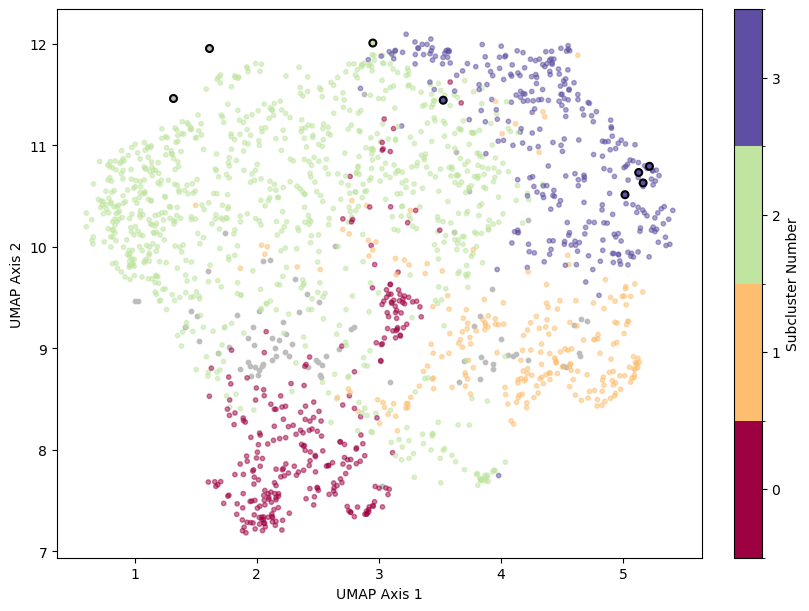

In [29]:
cluster_leaf = hdbscan.HDBSCAN(min_cluster_size=200,
                               min_samples=1,
                               metric='euclidean',
                               cluster_selection_method='leaf',
                               leaf_size=5,
                               prediction_data=True) \
                      .fit(umap_50comp_model.embedding_)

gen_embeds_clusters_leaf = hdbscan.approximate_predict(cluster_leaf, gen_embeds_umap_50comp)

result['labels_leaf'] = cluster_leaf.labels_
result_gen_embeds['labels_leaf'] = gen_embeds_clusters_leaf[0]

# note that average chat embeddings don't fall in a cluster
print(gen_embeds_clusters_leaf)

# Zoom in on cluster 0 to plot relevant subclusters that were learned by HDBSCAN
# prepare for visualization
outliers_leaf = result.loc[result.labels_leaf == -1, :]
clustered_leaf = result.loc[~result.labels_leaf.isin([0, -1]), :]
gen_ai_outliers_leaf = result_gen_embeds.loc[result_gen_embeds.labels_leaf == -1, :]
gen_ai_points_leaf = result_gen_embeds.loc[~result_gen_embeds.labels_leaf.isin([0, -1]), :]

# Visualize clusters (note that we're labeling each subcluster number to one integer value less than its label
# since clusters 1-3 above were all collapsed into a single label using leaf method -- 0 -- and we are not plotting these clusters
# in the zoomed-in plot); so subcluster 3 in the article (and the visualization below) is actually 4 in the `labels_leaf` column
# of the dataframe, and so on for labels 1-4. Label 0 in `labels_leaf` column is excluded from the plot, so
# -1 remains the label for outliers.
cmap = mpl.cm.Spectral
bounds = np.arange(1, result.labels_leaf.nunique())
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
tick_locs = bounds[:-1] + 0.5
tick_labels = np.arange(0, 4)

fig, ax = plt.subplots(figsize=(8, 6), layout='constrained')
plt.scatter(outliers_leaf.x, outliers_leaf.y, color='#BDBDBD', s=10) # grey
plt.scatter(clustered_leaf.x, clustered_leaf.y, c=clustered_leaf.labels_leaf, s=10, cmap=cmap, alpha=0.5)
plt.scatter(gen_ai_outliers_leaf.x, gen_ai_outliers_leaf.y, color='#BDBDBD', s=25, linewidths=1.5, edgecolors='k') # grey
plt.scatter(gen_ai_points_leaf.x, gen_ai_points_leaf.y, c=gen_ai_points_leaf.labels_leaf, s=25, linewidths=1.5, edgecolors='k', norm=norm, cmap=cmap)

cb = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), 
                  ax=ax, orientation='vertical', label='Subcluster Number')
cb.set_ticks(tick_locs)
cb.set_ticklabels(tick_labels)
plt.xlabel('UMAP Axis 1')
plt.ylabel('UMAP Axis 2');

Using the leaf method, we can see that 96\% of our abstracts have been assigned a cluster. Neither of the average embeddings for ChatGPT fall in the domain of a scholarly subcluster within cluster 0, however. All of the remaining average embeddings are assigned to subcluster 3, with the exception of the "expert" DALL-E 3 prompt revision, which was assigned to subcluster 2.

In [30]:
clustered_leaf_all = result.loc[~result.labels_leaf.isin([-1]), :]
len(clustered_leaf_all) / (len(outliers_leaf) + len(clustered_leaf_all))

0.9607367910809501

#### AI-generated content subcluster membership

Let's consider the subcluster membership of each AI-generated content category in more detail, plotting and counting the cluster membership of each example of AI-generated content (as opposed to the average alone). We'll use the following function for each category.

In [31]:
def plot_subcluster_membership(embeds, umap_50comp_model, cluster_leaf, result, category):
    gen_embeds_umap_50comp = umap_50comp_model.transform(embeds)
    gen_embeds_clusters_leaf = hdbscan.approximate_predict(cluster_leaf, gen_embeds_umap_50comp)
    gen_embeds_umap_2comp = umap_2comp_model.transform(embeds)

    # add transformed data to result dataframe
    result_gen_embeds = pd.DataFrame(gen_embeds_umap_2comp, columns=['x', 'y'])

    result_gen_embeds['labels_leaf'] = gen_embeds_clusters_leaf[0]

    # print out cluster percentages
    print(category)
    for i in result_gen_embeds.groupby('labels_leaf').x.count().items():
        if i[0] != -1:
            print(f'{i[1]}% in Subcluster {i[0] - 1}')
        else:
            print(f'{i[1]}% not in any identified subcluster')
    print('\n')

    # prepare for visualization
    outliers_leaf = result.loc[result.labels_leaf == -1, :]
    clustered_leaf = result.loc[~result.labels_leaf.isin([0, -1]), :]
    gen_ai_outliers_leaf = result_gen_embeds.loc[result_gen_embeds.labels_leaf == -1, :]
    gen_ai_points_leaf = result_gen_embeds.loc[~result_gen_embeds.labels_leaf.isin([0, -1]), :]

    # Visualize clusters
    cmap = mpl.cm.Spectral
    bounds = np.arange(1, result.labels_leaf.nunique())
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    tick_locs = bounds[:-1] + 0.5
    tick_labels = np.arange(0, 4)

    fig, ax = plt.subplots(figsize=(8, 6), layout='constrained')
    plt.scatter(outliers_leaf.x, outliers_leaf.y, color='#BDBDBD', s=10) # grey
    plt.scatter(clustered_leaf.x, clustered_leaf.y, c=clustered_leaf.labels_leaf, s=10, cmap=cmap, alpha=0.5)
    plt.scatter(gen_ai_outliers_leaf.x, gen_ai_outliers_leaf.y, color='#BDBDBD', s=25, linewidths=1.5, edgecolors='k') # grey
    plt.scatter(gen_ai_points_leaf.x, gen_ai_points_leaf.y, c=gen_ai_points_leaf.labels_leaf, s=25, linewidths=1.5, edgecolors='k', norm=norm, cmap=cmap)

    cb = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), 
                    ax=ax, orientation='vertical', label='Subcluster Number')
    cb.set_ticks(tick_locs)
    cb.set_ticklabels(tick_labels)
    plt.xlabel('UMAP Axis 1')
    plt.ylabel('UMAP Axis 2');

##### ChatGPT subcluster membership

ChatGPT (general)
82% not in any identified subcluster
17% in Subcluster 2
1% in Subcluster 3




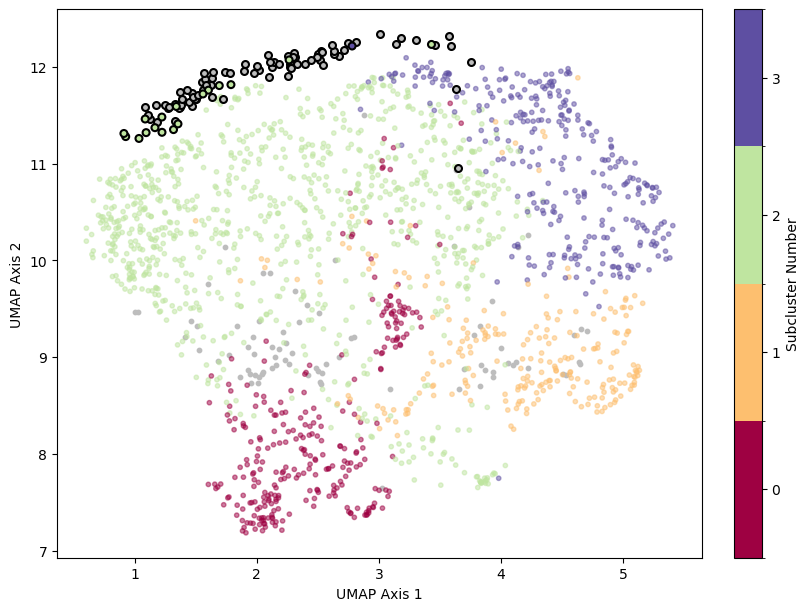

In [32]:
embeds = chat_response_embeds_np['general']['embeds']
plot_subcluster_membership(embeds, umap_50comp_model, cluster_leaf, result, f'ChatGPT (general)')

ChatGPT (expert)
51% not in any identified subcluster
49% in Subcluster 2




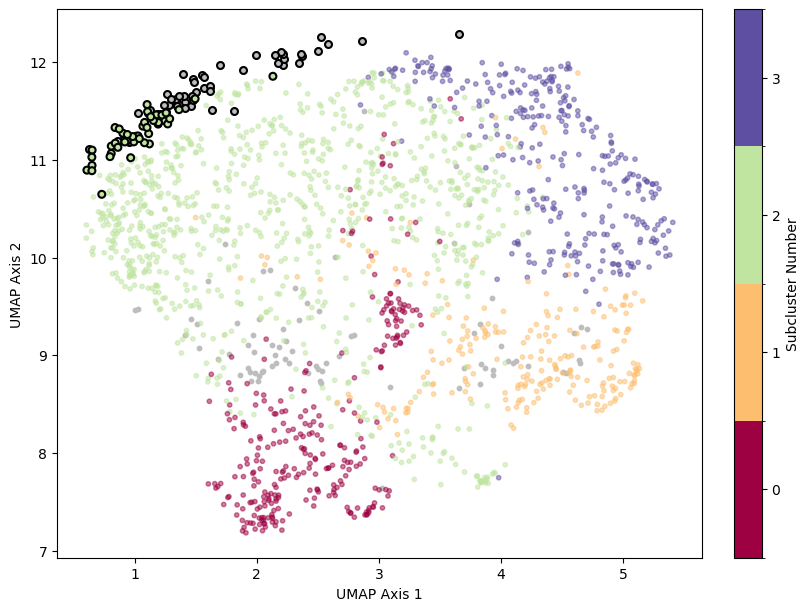

In [33]:
embeds = chat_response_embeds_np['expert']['embeds']
plot_subcluster_membership(embeds, umap_50comp_model, cluster_leaf, result, f'ChatGPT (expert)')

##### DALL-E 3 revised prompt subcluster membership

DALL-E 3 revised prompt (general)
53% not in any identified subcluster
28% in Subcluster 2
19% in Subcluster 3




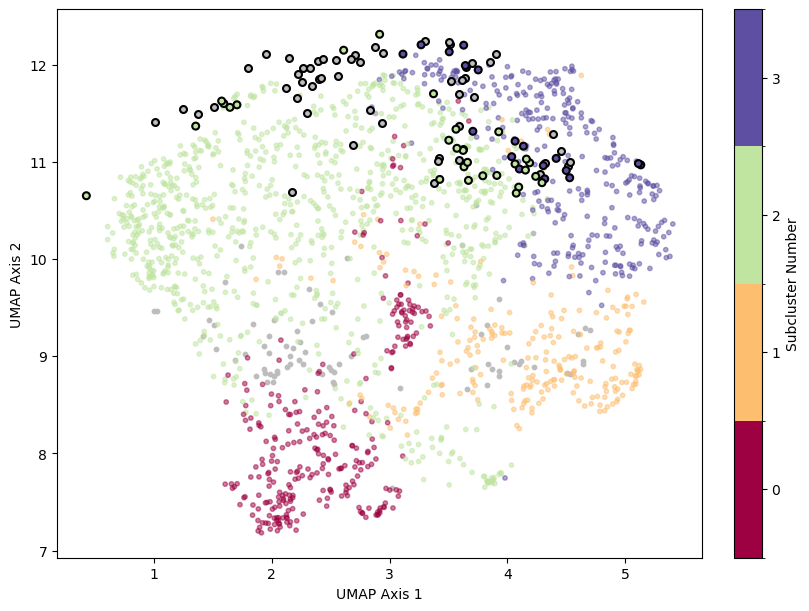

In [34]:
embeds = gen_img_embeds_np['rev_general']['revised_prompt_embeds']
plot_subcluster_membership(embeds, umap_50comp_model, cluster_leaf, result, f'DALL-E 3 revised prompt (general)')

DALL-E 3 revised prompt (expert)
51% not in any identified subcluster
28% in Subcluster 2
21% in Subcluster 3




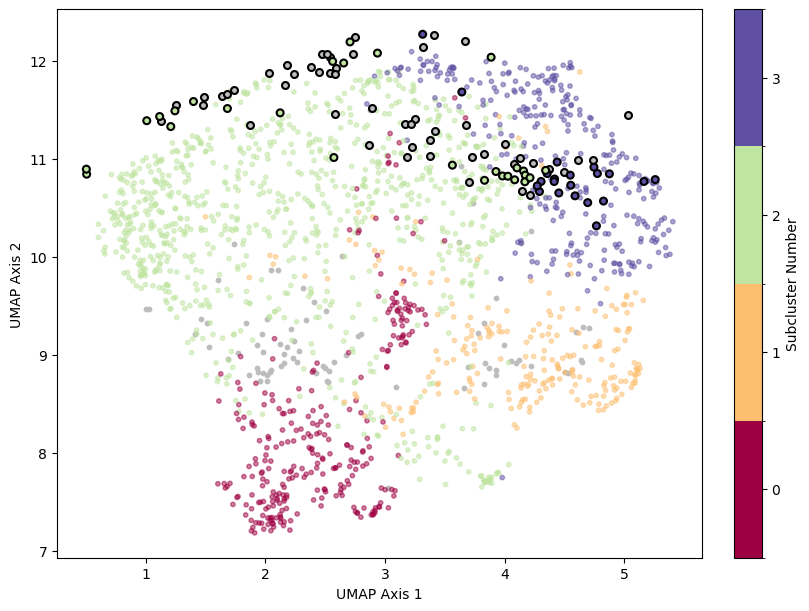

In [35]:
embeds = gen_img_embeds_np['rev_expert']['revised_prompt_embeds']
plot_subcluster_membership(embeds, umap_50comp_model, cluster_leaf, result, f'DALL-E 3 revised prompt (expert)')

##### DALL-E 3 image subcluster membership

DALL-E 3 Images (all)
69% not in any identified subcluster
3% in Subcluster 2
328% in Subcluster 3




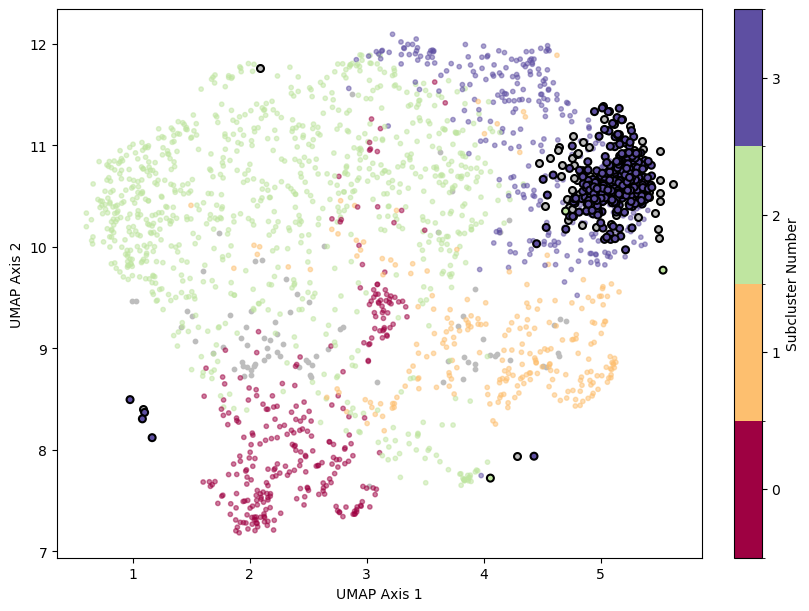

In [36]:
embeds = np.concatenate([gen_img_embeds_np['rev_general']['img_embeds'],
                         gen_img_embeds_np['rev_expert']['img_embeds'],
                         gen_img_embeds_np['norev_general']['img_embeds'],
                         gen_img_embeds_np['norev_expert']['img_embeds']])
plot_subcluster_membership(embeds, umap_50comp_model, cluster_leaf, result, f'DALL-E 3 Images (all)')

DALL-E 3 Images (general, with prompt revisions)
7% not in any identified subcluster
93% in Subcluster 3




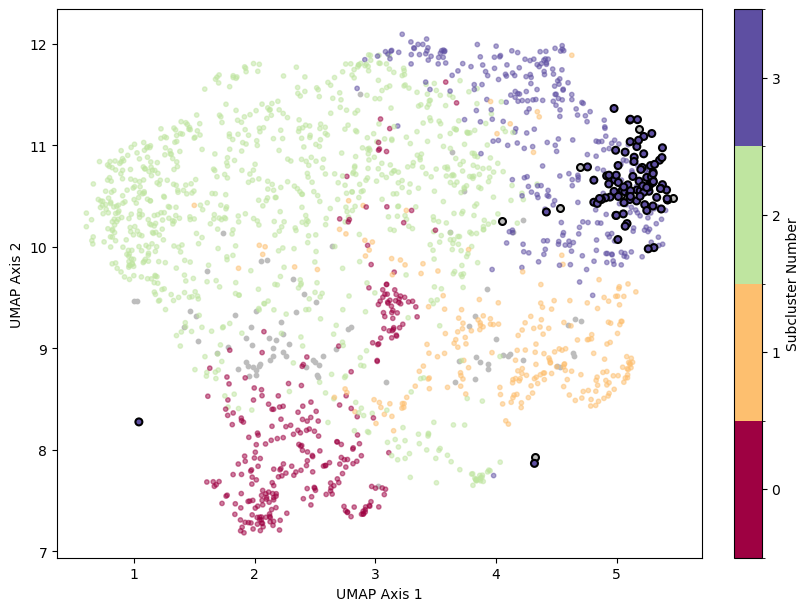

In [37]:
embeds = gen_img_embeds_np['rev_general']['img_embeds']
plot_subcluster_membership(embeds, umap_50comp_model, cluster_leaf, result, f'DALL-E 3 Images (general, with prompt revisions)')

DALL-E 3 Images (expert, with prompt revisions)
28% not in any identified subcluster
72% in Subcluster 3




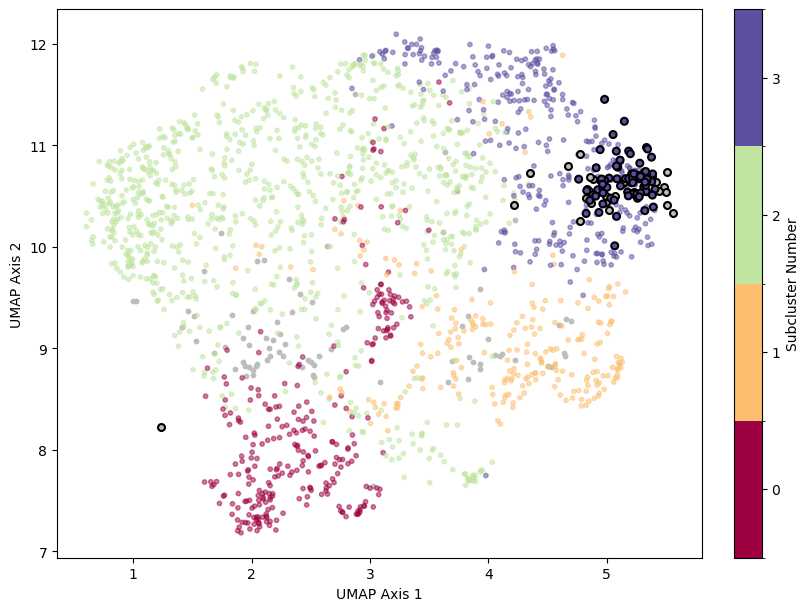

In [38]:
embeds = gen_img_embeds_np['rev_expert']['img_embeds']
plot_subcluster_membership(embeds, umap_50comp_model, cluster_leaf, result, f'DALL-E 3 Images (expert, with prompt revisions)')


DALL-E 3 Images (general, without prompt revisions)
23% not in any identified subcluster
1% in Subcluster 2
76% in Subcluster 3




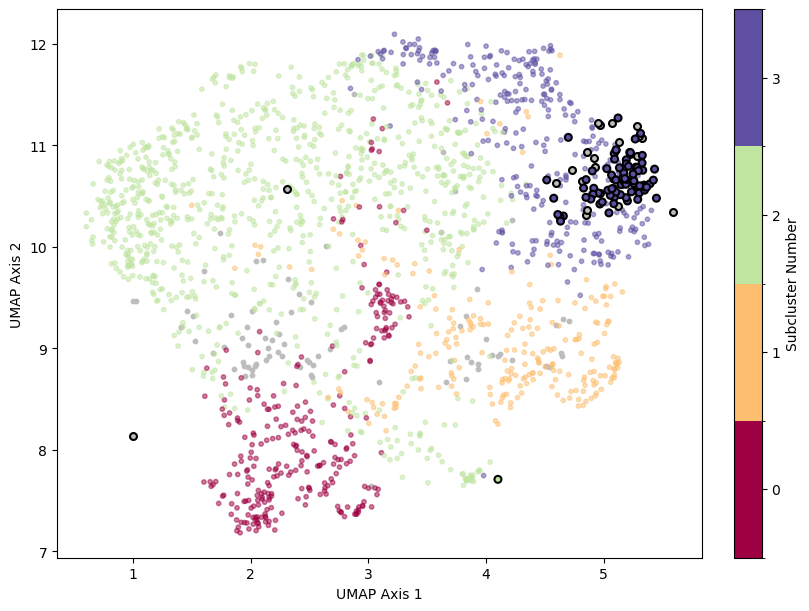

In [39]:
embeds = gen_img_embeds_np['norev_general']['img_embeds']
plot_subcluster_membership(embeds, umap_50comp_model, cluster_leaf, result, f'DALL-E 3 Images (general, without prompt revisions)')

DALL-E 3 Images (expert, without prompt revisions)
14% not in any identified subcluster
2% in Subcluster 2
84% in Subcluster 3




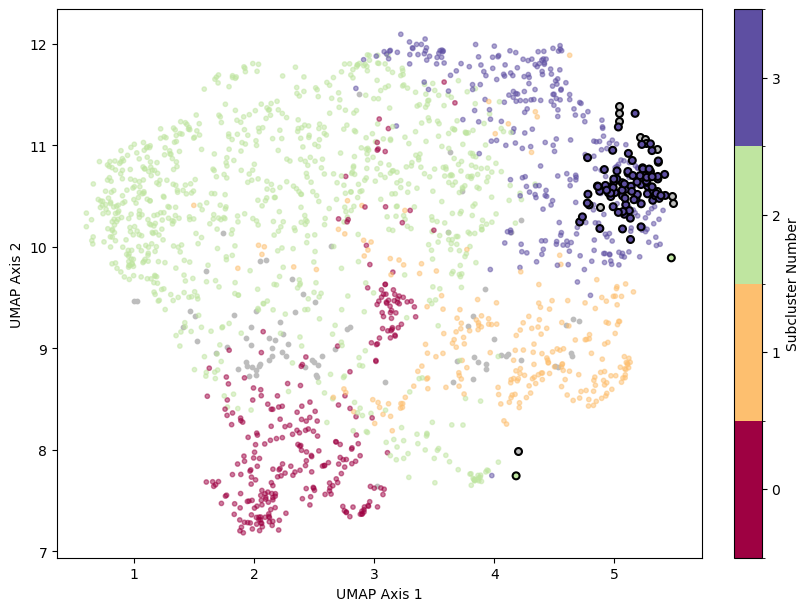

In [40]:
embeds = gen_img_embeds_np['norev_expert']['img_embeds']
plot_subcluster_membership(embeds, umap_50comp_model, cluster_leaf, result, f'DALL-E 3 Images (expert, without prompt revisions)')

Let's take a look at the types of articles that occur in each one of the subclusters.

#### Subcluster 0

In [41]:
abstract_embeds = abstract_embeds.join(clustered_leaf, rsuffix='_join')
print(abstract_embeds.loc[abstract_embeds.labels_leaf == 1].publicationYear.describe())
abstract_embeds.loc[abstract_embeds.labels_leaf == 1].loc[:, ['publicationYear', 'abstract']].head(10)

count     290.000000
mean     2011.513793
std         7.658463
min      1967.000000
25%      2008.000000
50%      2014.000000
75%      2017.000000
max      2022.000000
Name: publicationYear, dtype: float64


publicationYear  \
0              2020   
2              2017   
8              2015   
16             2020   
27             2009   
30             2009   
35             2013   
36             2013   
46             2008   
61             2015   

                                                                                                                                                                                                   abstract  
0   The new radiocarbon calibration curve (IntCal20) allows us to calculate the gradient of the relationship between 14C age and calendar age over the past 55 millennia before the present (55 ka BP). ...  
2   Biosynthesis of the common mammalian sialic acid N-glycolylneuraminic acid (Neu5Gc) was lost during human evolution due to inactivation of the CMAH gene, possibly expediting divergence of the Homo...  
8   Germline mutations are the principal cause of heritable disease and the ultimate source of evolutionary change. Similarly, somatic mutations are the primary cause of cancer and may contribute to t...  
16  The incidence of introgression during the diversification process and the timespan following divergence when introgression is possible are poorly understood in the neotropics where high species ri...  
27  The advent and maturation of algorithms for estimating species trees-phylogenetic trees that allow gene tree heterogeneity and whose tips represent lineages, populations and species, as opposed to...  
30  Aim The aims of this study were to assess the distribution of putative Mediterranean refugia of plants, to compare the locations of refugia and those of regional hotspots of plant biodiversity, an...  
35  Aim: The biotic mechanisms by which land bridges influence the formation of regional floras remain poorly understood. We tested the hypothesis that some land bridges have biased the migration of s...  
36  Data, whether images, measurements, counts, occurrences, or character codings, are a cornerstone of vertebrate paleontology. Every published paper, master's thesis, and doctoral dissertation relie...  
46                                                                                                  Paleogenomic researchers are finding new ways to solve the problems of sample rarity and contamination.  
61  Cerebral organoids—3D cultures of human cerebral tissue derived from pluripotent stem cells—have emerged as models of human cortical development. However, the extent to which in vitro organoid sys...

#### Subcluster 1

In [42]:
print(abstract_embeds.loc[abstract_embeds.labels_leaf == 2].publicationYear.describe())
abstract_embeds.loc[abstract_embeds.labels_leaf == 2].loc[:, ['publicationYear', 'abstract']].head(10)

count     235.000000
mean     2005.595745
std        13.160189
min      1933.000000
25%      2001.000000
50%      2008.000000
75%      2015.000000
max      2020.000000
Name: publicationYear, dtype: float64


publicationYear  \
5              2019   
7              2005   
11             2018   
18             1997   
23             2003   
42             2020   
50             2008   
53             2007   
67             2011   
75             2016   

                                                                                                                                                                                                   abstract  
5   This paper describes the most interesting diseases observed in skeletal samples from two necropolises found in Shirak and Lori provinces during archaeological excavations in the last decades and c...  
7   A longstanding controversy in paleoanthropology surrounds the question of whether Neandertals shared the prolonged growth periods of modern humans. To address this question, this investigation com...  
11  The human birth canal shows a tight fit with the size of the neonate, which can lead to obstetric complications. This is not the case in other apes, and has been explained as the outcome of confli...  
18  High‐latitude modern humans with traditional diets must maintain a critical ratio of dietary fat to protein. An analysis of 15 New World Arctic groups reveals that the abundance and predict abilit...  
23  Ecomorphological and biogeochemical (trace element, and carbon, nitrogen, and oxygen isotope ratios) analyses have been used for determining the dietary niches and habitat preferences of large mam...  
42  The surface of the human cerebellar cortex is much more tightly folded than the cerebral cortex. It was computationally reconstructed for the first time to the level of all individual folia from m...  
50  There are surprisingly few experimental models of neural growth and cranial integration. This, and the dearth of information regarding fetal brain development, detracts from a mechanistic understa...  
53  Human speech involves species‐specific anatomy deriving from the descent of the tongue into the pharynx. The human tongue’s shape and position yields the 1:1 oral‐to‐pharyngeal proportions of the ...  
67  A large and varied avifaunal bone assemblage from the final Mousterian levels of Grotta di Fumane, northern Italy, reveals unusual human modifications on species that are not clearly relatable to ...  
75  The moa (Dinornithiformes) are large to gigantic extinct terrestrial birds of New Zealand. Knowledge about niche partitioning, feeding mode and preference among moa species is limited, hampering p...

#### Subcluster 2

In [43]:
print(abstract_embeds.loc[abstract_embeds.labels_leaf == 3].publicationYear.describe())
abstract_embeds.loc[abstract_embeds.labels_leaf == 3].loc[:, ['publicationYear', 'abstract']].head(10)

count     902.000000
mean     2004.840355
std        14.123563
min      1923.000000
25%      1999.000000
50%      2009.000000
75%      2015.000000
max      2023.000000
Name: publicationYear, dtype: float64


publicationYear  \
6              1990   
9              2017   
10             2014   
13             1994   
14             2013   
15             1998   
20             2011   
25             2016   
28             2017   
29             2011   

                                                                                                                                                                                                   abstract  
6   The familiar debate concerning Middle Paleolithic variability has opposed stylistic vs. functional explanations based on the assumption that tool types and assemblage groups represent discrete, in...  
9   Human behavior is shaped by social learning to an extent that is unrivaled in the natural world. What neurobiological changes have occurred in human evolutionary history that have enabled this rem...  
10  Human knowledge is a human creation: we seek to make sense by creating patterns, which are tested in various ways and with differing degrees and kinds of rigour. For each individual cognition is a...  
13  Early modern and archaic humans are associated with similar lithic industries in the Middle Paleolithic of the southern Levant, but new data suggest that they used the environment in different way...  
14  “Pygmy populations” are recognized in several places over the world, especially in Western Africa and in Southeast Asia (Philippine “negritos,” for instance). Broadly defined as “small-bodied Homo...  
15  Whether ecosystems are structured from the top-down (i.e., predator driven) or bottom-up (i.e., food limited) has been debated by ecologists for nearly a century. Many marine and freshwater aquati...  
20  Although many species display behavioural traditions, human culture is unique in the complexity of its technological, symbolic and social contents. Is this extraordinary complexity a product of co...  
25  Homo sapiens phylogeography begins with the species’ origin nearly 200 kya in Africa. First signs of the species outside Africa (in Arabia) are from 125 kya. Earliest dates elsewhere are now 100 k...  
28  Present-day hunter-gatherers (HGs) live in multilevel social groups essential to sustain a population structure characterized by limited levels of within-band relatedness and inbreeding. When thes...  
29  Animals behave cooperatively towards certain conspecifics while being indifferent or even hostile to others. The distinction is made primarily according to kinship as predicted by the kin selectio...

#### Subcluster 3

In [44]:
print(abstract_embeds.loc[abstract_embeds.labels_leaf == 4].publicationYear.describe())
abstract_embeds.loc[abstract_embeds.labels_leaf == 4].loc[:, ['publicationYear', 'abstract']].head(10)

count     303.000000
mean     2004.448845
std        12.469162
min      1936.000000
25%      1999.000000
50%      2008.000000
75%      2013.500000
max      2023.000000
Name: publicationYear, dtype: float64


publicationYear  \
1               2017   
4               2010   
19              2003   
21              1985   
24              2001   
48              1996   
59              1995   
84              1966   
107             1979   
121             2009   

                                                                                                                                                                                                    abstract  
1    Our traditional scheme during the twentieth century was that Homo erectus had thrived on the vast terrain of eastern Asia since the Early Pleistocene, followed by the appearance of a more advanced...  
4    The idea of an evolutionary sequence for humans is quite recent. Over the last 150 years, we have discovered unexpected ancestors, numerous close relatives and our deep evolutionary roots in Afric...  
19   This paper examines the character of the main human economic activity which took place at the site of Klithi, in Epirus (16,000-13,500 BP), namely the hunting and exploitation of ibex (Capra ibex)...  
21   Zhoukoudian is often cited as yielding some of the earliest evidence for the use of fire and as documenting "man the hunter" living in caves during the Middle Pleistocene. In addition, it is commo...  
24   A survey of open-air sites in NW Turkey identified 16 Palaeolithic sites. Analysis of nearly 2000 lithics identified Lower, Middle, and Early Upper Palaeolithic (EUP) components. The Lower Palaeol...  
48   The ability to identify distinct types of cherts and chalcedonies at the large prehistoric housepit site of Keatley Creek on the British Columbia plateau has made it possible to infer important as...  
59   Recent discoveries have greatly clarified the family tree relationships of Miocene apes to modern apes and humans. Contrary to most previous interpretations, new fossil evidence indicates that wel...  
84   At the terminal period of the Mousterian, the Upper Palaeolithic artifacts became more abundant in a number of beds. Some deposits present a tool assemblage dominated by small, odd, worn flakes, m...  
107  The ideas about the distribution of the earliest sites in Soviet Central Asia and the character of Paleolithic industries which have been formed by Western archaeologist through the works of Moviu...  
121  A comparison is made between the scientific receptions of three proposed new members of the hominin phylogenetic tree: the first finds of Neanderthal Man, those of Homo erectus, and those of Homo ...

### Estimating Average Closest Publication Year to AI Generated Content

Finally, we assess the average closest publication year to each one of our AI generated content categories. Does AI-generated content tend toward the newer content within each scholarly content cluster, or older?

This question can be answered by first assessing the semantic similarity between each abstract (each of which we know the publication year of its corresponding article) and the average of each AI-generated category:

In [ ]:
# Compute cosine similarity between each abstract and average of each generated image category
for k in gen_img_embeds_np.keys():
    abstract_embeds.loc[:, f'img_sim_{k}'] = 1 - cdist(np.stack(abstract_embeds.embed),
                                                       gen_img_embeds_np[k]['img_avg'].reshape(1, -1), 
                                                       'cosine').reshape(-1)
                                                                        
# Compute cosine similarity between each abstract and average of each category of generated text embeddings (at DALL-E 3 prompt level, as well as ChatGPT responses)
for k in ['general', 'expert']:

    abstract_embeds.loc[:, f'prompt_sim_rev_{k}'] = 1 - cdist(np.stack(abstract_embeds.embed),
                                                       gen_img_embeds_np[f'rev_{k}']['revised_prompt_avg'].reshape(1, -1), 
                                                       'cosine').reshape(-1)
    abstract_embeds.loc[:, f'chat_sim_{k}'] = 1 - cdist(np.stack(abstract_embeds.embed),
                                                       chat_response_embeds_np[k]['avg'].reshape(1, -1), 
                                                       'cosine').reshape(-1)

There are 77 years of data in the dataset, so the closest 25% of years to any one point would be around 20 years:

In [46]:
np.sum(abstract_embeds.groupby('publicationYear').publicationYear.count() > 0) * .25

19.25

As a measure of the "age" of a AI-generated content, we thus identified the 20 publication years with scholarly abstracts that were closest on average to each of our AI-generated content averages (i.e. using the nearest 25\% as our arbitrary percentile threshold). To arrive at a single "age" for the AI-generated content, we finally averaged these 20 closest publication years.

The images seem to be most similar to abstracts from the 1980's and 1990s, while the DALL-E 3 revised prompts are closer to the 1970s:

In [47]:
for k in gen_img_embeds_np.keys():
    print(f'{k} (image)', np.mean(abstract_embeds.groupby('publicationYear') \
                 .agg({f'img_sim_{k}': ['mean']}) \
                 .sort_values(by=(f'img_sim_{k}', 'mean'), ascending=False) \
                 .head(20) \
                 .index))
    if 'no' not in k:
        print(f'prompt_{k} (text)', np.mean(abstract_embeds.groupby('publicationYear') \
                 .agg({f'prompt_sim_{k}': ['mean']}) \
                 .sort_values(by=(f'prompt_sim_{k}', 'mean'), ascending=False) \
                 .head(20) \
                 .index))

rev_general (image) 1985.55
prompt_rev_general (text) 1970.7
rev_expert (image) 1991.05
prompt_rev_expert (text) 1974.0
norev_general (image) 1987.4
norev_expert (image) 1991.05


The ChatGPT responses are most similar to older article abstracts -- with averages in the early 1960s (and virtually indistinguishable performance between the "general" and "expert" prompts):

In [48]:
for k in ['chat_sim_general', 'chat_sim_expert']:
    print(k, np.mean(abstract_embeds.groupby('publicationYear') \
                                    .agg({k: ['mean']}) \
                                    .sort_values(by=(k, 'mean'), ascending=False) \
                                    .head(20) \
                                    .index))

chat_sim_general 1963.85
chat_sim_expert 1962.4


This does not seem to simply be a characteristic of their cluster membership (i.e. one hypothesis might be that every article in the semantic cluster they belong to belongs to a similar publication year range). Note that the AI-generated content is closest to the oldest scholarly articles within each cluster it is assigned. ChatGPT and the DALL-E 3 prompt revisions lean toward the publication year outliers of each cluster they belong to:

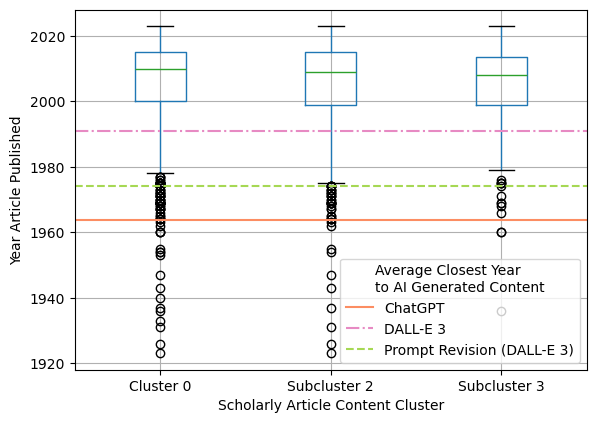

In [49]:
full_cluster = abstract_embeds.loc[abstract_embeds.labels == 0, ['labels', 'publicationYear']]
sub_clusters = abstract_embeds.loc[abstract_embeds.labels_leaf.isin([3, 4]), ['labels_leaf', 'publicationYear']]
sub_clusters.columns = ['labels', 'publicationYear']

cmap = mpl.colormaps['Set2']

# using latest possible year for each category as conservative estimate
pd.concat([full_cluster, sub_clusters]).boxplot('publicationYear', by='labels')
plt.axhline(1963.85, label='ChatGPT', color=cmap.colors[1])
plt.axhline(1991.05, label='DALL-E 3', color=cmap.colors[3], linestyle='dashdot')
plt.axhline(1974, label='Prompt Revision (DALL-E 3)', color=cmap.colors[4], linestyle='dashed')
plt.xticks([1, 2, 3], ['Cluster 0', 'Subcluster 2', 'Subcluster 3'])
plt.xlabel('Scholarly Article Content Cluster')
plt.ylabel('Year Article Published')
plt.legend(title='Average Closest Year\nto AI Generated Content')
plt.title('')
plt.suptitle('');

#### Most salient words in closest era to AI-generated content

Finally, to better assess the type of language that best corresponded to the average closest year that the AI-generated content was closest to, we computed the average TF-IDF value for every word in scholarly article abstracts five years before and after each identified year. The function below removes stop words and identifies the top 20 most-salient words (i.e. highest average TF-IDF) in the 10-year period surrounding the average closest year for a given category of AI-generated content:

In [50]:
stopwords = set(nltk.corpus.stopwords.words('english')) \
            | set(nltk.corpus.stopwords.words('french')) \
            | set(nltk.corpus.stopwords.words('german')) \
            | set(nltk.corpus.stopwords.words('hebrew'))

extended_stopwords_url = 'https://gist.githubusercontent.com/rg089/35e00abf8941d72d419224cfd5b5925d/raw/12d899b70156fd0041fa9778d657330b024b959c/stopwords.txt'
extended_stopwords_list = requests.get(extended_stopwords_url) \
                                  .content \
                                  .decode() \
                                  .splitlines()
study_specific_stopwords_list = ['paper', 'papers', 'study', 'studies', 'data', 'analysis',
                                 'analyses', 'year', 'years', 'ago', 'early', 'time', 'times',
                                 'evidence', 'site', 'sites', 'period', 'periods', 'result',
                                 'results', 'hypothesis', 'hypotheses', 'discussion', 'discusses',
                                 'discuss', 'discussed', 'comme']
stopwords = stopwords.union(set(extended_stopwords_list + study_specific_stopwords_list))

def top_n_most_salient_words(text, n):
    # identify tokens and co-occuring tokens (i.e. "phrases")
    text_no_stop = text.str.lower().apply(lambda x: ' '.join([word for word in str(x).split() if word not in stopwords]))
    tokens = [simple_preprocess(str(t), deacc=True) for t in text_no_stop]
    phrases = Phrases(tokens, min_count=1, threshold=2)

    # convert to bag of words format and add to corpus
    dictionary = Dictionary()
    corpus = [dictionary.doc2bow(phrases[t], allow_update=True) for t in tokens]
    
    # Compute TF-IDF weighted by:
    # (L) average-term-frequency based normalization
    # (t) inverse collection frequency
    # (c) cosine normalization
    model = TfidfModel(corpus, smartirs='Ltc')

    # identify most salient tokens and phrases overall (by average TF-IDF)
    vocab = [dictionary[i] for i in range(len(dictionary))]
    df = pd.DataFrame(data=np.zeros((len(corpus), len(vocab)), dtype=np.float32),
                      index=np.arange(len(corpus)),
                      columns=vocab
    )
    for i in range(len(corpus)):
        for id, freq in model[corpus[i]]:
            df.loc[i, dictionary[id]] = np.float32(freq)

    most_salient = df.mean().sort_values(ascending=False).head(n)
    return most_salient

##### ChatGPT (General)

In [51]:
year_closest_to_chatgpt = 1963.85
abstracts_around_year_chatgpt = abstract_embeds.loc[abstract_embeds.publicationYear.isin(np.arange(round(year_closest_to_chatgpt - 5),
                                                                                                   round(year_closest_to_chatgpt + 5)))].abstract
top_n_most_salient_words(text=abstracts_around_year_chatgpt,
                         n=20)

biology          0.021300
evolution        0.020507
occurence        0.019656
human_ecology    0.019079
neanderthal      0.018725
human            0.018650
development      0.018192
africa           0.017893
man              0.017598
shanidar         0.016849
tabun            0.016849
caracteres       0.016705
nature           0.016437
hominid          0.016196
hominoid         0.016121
problems         0.015950
homo_sapiens     0.015807
modern           0.015782
culture          0.015481
physical         0.015351
dtype: float32

##### ChatGPT (Expert)

In [52]:
year_closest_to_chatgpt = 1962.4
abstracts_around_year_chatgpt = abstract_embeds.loc[abstract_embeds.publicationYear.isin(np.arange(round(year_closest_to_chatgpt - 5),
                                                                                                   round(year_closest_to_chatgpt + 5)))].abstract
top_n_most_salient_words(text=abstracts_around_year_chatgpt,
                         n=20)

occurence              0.027994
evolution              0.025646
development            0.024618
shanidar               0.024130
tabun                  0.024130
africa                 0.024042
human_ecology          0.023696
caracteres             0.023610
hominoid               0.022353
nature                 0.021651
cranial_capacity       0.021482
oreopithecus           0.021482
culture                0.021194
homo_sapiens           0.021125
depression             0.020998
threshold_amplitude    0.020998
waveform               0.020998
dawson                 0.020558
human                  0.020180
stage                  0.019492
dtype: float32

##### DALL-E 3 (General, with prompt revisions)

In [53]:
year_closest_to_dalle = 1985.55
abstracts_around_year_dalle = abstract_embeds.loc[abstract_embeds.publicationYear.isin(np.arange(round(year_closest_to_dalle - 5),
                                                                                                 round(year_closest_to_dalle + 5)))].abstract
top_n_most_salient_words(text=abstracts_around_year_dalle,
                         n=20,
)

homo_sapiens      0.011528
evolution         0.010450
human             0.009537
homo_erectus      0.009315
assemblages       0.008787
species           0.008554
genetic           0.008270
archaeological    0.008261
cave              0.008210
samples           0.008075
populations       0.007923
social            0.007828
sapiens           0.007825
paleolithic       0.007753
region            0.007672
biological        0.007648
selection         0.007647
development       0.007630
change            0.007488
pleistocene       0.007411
dtype: float32

##### DALL-E 3 (General, without prompt revisions)

In [54]:
year_closest_to_dalle = 1987.4
abstracts_around_year_dalle = abstract_embeds.loc[abstract_embeds.publicationYear.isin(np.arange(round(year_closest_to_dalle - 5),
                                                                                                 round(year_closest_to_dalle + 5)))].abstract
top_n_most_salient_words(text=abstracts_around_year_dalle,
                         n=20,
)


homo_sapiens          0.011322
human                 0.010153
evolution             0.009847
populations           0.009439
assemblages           0.009088
middle_paleolithic    0.008835
homo_erectus          0.008680
neandertals           0.008479
modern_humans         0.008469
paleolithic           0.008441
sapiens               0.008243
cave                  0.008107
social                0.007880
age                   0.007742
samples               0.007730
development           0.007668
species               0.007585
variation             0.007575
individuals           0.007448
archaeological        0.007419
dtype: float32

##### DALL-E 3 (Expert, with and without prompt revisions)

In [55]:
year_closest_to_dalle = 1991.05
abstracts_around_year_dalle = abstract_embeds.loc[abstract_embeds.publicationYear.isin(np.arange(round(year_closest_to_dalle - 5),
                                                                                                 round(year_closest_to_dalle + 5)))].abstract
top_n_most_salient_words(text=abstracts_around_year_dalle,
                         n=20,
)


human                 0.011376
age                   0.009987
archaeological        0.009908
middle_paleolithic    0.009906
modern_humans         0.009885
populations           0.009172
humans                0.008523
region                0.008359
evolution             0.007994
dating                0.007808
assemblages           0.007637
patterns              0.007579
cave                  0.007569
language              0.007547
europe                0.007471
bone                  0.007369
remains               0.007265
industries            0.007190
development           0.007055
africa                0.007011
dtype: float32

##### DALL-E 3 Prompt Revision (General)

In [56]:
year_closest_to_dalle_prompt_rev = 1970.7
abstracts_around_year_dalle_prompt_rev = abstract_embeds.loc[abstract_embeds.publicationYear.isin(np.arange(round(year_closest_to_dalle_prompt_rev - 5),
                                                                                                 round(year_closest_to_dalle_prompt_rev + 5)))].abstract
top_n_most_salient_words(text=abstracts_around_year_dalle_prompt_rev,
                         n=20,
)

human             0.014427
evolution         0.014419
cultural          0.013884
archaeological    0.013414
variation         0.012694
asia              0.011562
tool              0.011439
population        0.011388
fossil            0.011329
change            0.011259
neanderthal       0.011180
shift             0.010940
neanderthals      0.010811
modern            0.010805
burial            0.010803
physical          0.010708
hominids          0.010511
evolutionary      0.010411
biology           0.010357
man               0.010329
dtype: float32

##### DALL-E 3 Prompt Revision (Expert)

In [57]:
year_closest_to_dalle_prompt_rev = 1974
abstracts_around_year_dalle_prompt_rev = abstract_embeds.loc[abstract_embeds.publicationYear.isin(np.arange(round(year_closest_to_dalle_prompt_rev - 5),
                                                                                                 round(year_closest_to_dalle_prompt_rev + 5)))].abstract
top_n_most_salient_words(text=abstracts_around_year_dalle_prompt_rev,
                         n=20,
)

evolution            0.015315
human                0.013891
cultural             0.012717
archaeological       0.012073
variation            0.011777
hominid              0.011684
homo_sapiens         0.011593
morphological        0.011490
teeth                0.011378
language             0.011083
hominids             0.011057
change               0.010987
modern               0.010795
fossil               0.010510
population           0.010267
problems             0.009922
burial               0.009684
development          0.009619
upper_paleolithic    0.009551
aspects              0.009524
dtype: float32